# 🧠 Mercor AI Text Detection — Stacking Ensemble Notebook

This notebook builds a full stacking and blending pipeline for the Mercor AI Text Detection Kaggle competition.  
It includes:
- TF-IDF and feature engineering
- Multiple base models (Logistic Regression, Random Forest, XGBoost, LightGBM)
- Meta-model stacking (LGBM / Logistic Regression)
- Final submission generation (`stacked_submission.csv`, `stacked_submission_2.csv`, `super_blend_submission.csv`)

## 👨‍💻 Authors
**Gaurav Singh** & **Ayush Gahtori**

In [32]:
import warnings
import sys, os
from contextlib import contextmanager
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [33]:
train_path = "../Mecor_Data/train.csv"
test_path = "../Mecor_Data/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("✅ Data loaded successfully!")

for df in [train_df, test_df]:
    df["text_length"] = df["answer"].apply(len)
    df["num_words"] = df["answer"].apply(lambda x: len(x.split()))
    df["num_digits"] = df["answer"].apply(lambda x: sum(c.isdigit() for c in x))
    df["num_upper"] = df["answer"].apply(lambda x: sum(c.isupper() for c in x))

print("✅ Added new text-based features:")

✅ Data loaded successfully!
✅ Added new text-based features:


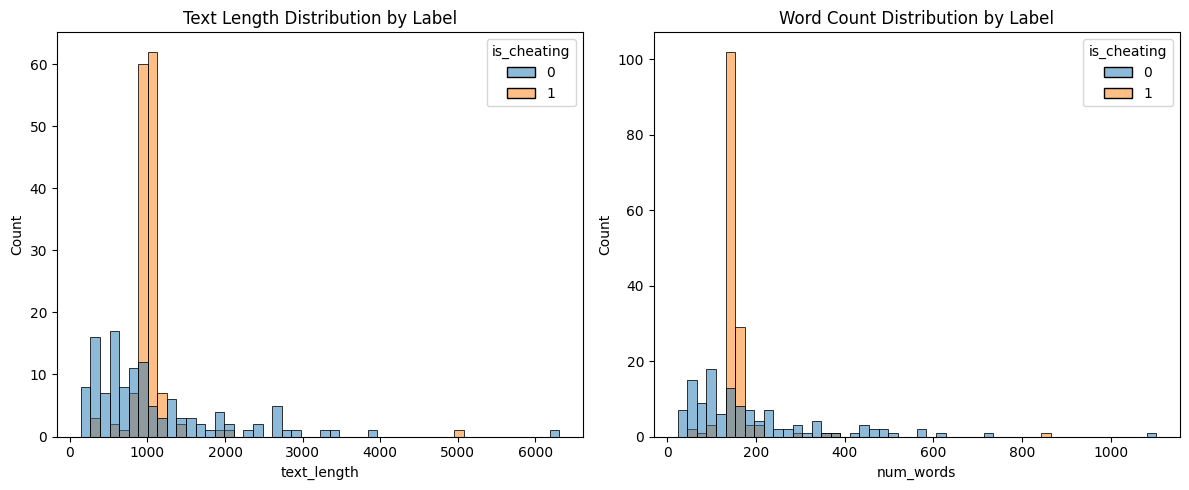

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=train_df, x='text_length', bins=50, hue='is_cheating', ax=axes[0])
axes[0].set_title("Text Length Distribution by Label")

sns.histplot(data=train_df, x='num_words', bins=50, hue='is_cheating', ax=axes[1])
axes[1].set_title("Word Count Distribution by Label")

plt.tight_layout()
plt.show()

In [35]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2), stop_words='english')
X_tfidf = vectorizer.fit_transform(train_df['answer'])
X_test_tfidf = vectorizer.transform(test_df['answer'])

num_features = ['text_length', 'num_words', 'num_digits', 'num_upper']
X_train_combined = hstack([X_tfidf, train_df[num_features].values])
X_test_combined = hstack([X_test_tfidf, test_df[num_features].values])

y = train_df['is_cheating']

print("✅ Combined TF-IDF and numeric features!")

✅ Combined TF-IDF and numeric features!


In [36]:
train_df = pd.read_csv("../Mecor_Data/train.csv")
test_df = pd.read_csv("../Mecor_Data/test.csv")

y = train_df["is_cheating"]

In [37]:
tfidf_topic = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_answer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_topic_train = tfidf_topic.fit_transform(train_df["topic"])
X_answer_train = tfidf_answer.fit_transform(train_df["answer"])

X_topic_test = tfidf_topic.transform(test_df["topic"])
X_answer_test = tfidf_answer.transform(test_df["answer"])

X_train_combined = hstack([X_topic_train, X_answer_train])
X_test_combined = hstack([X_topic_test, X_answer_test])


In [38]:
warnings.filterwarnings("ignore")

@contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

base_models = {
    "lr": LogisticRegression(max_iter=1000, solver='liblinear'),
    "rf": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "xgb": XGBClassifier(eval_metric='logloss', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42),
    "lgb": LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

oof_preds = np.zeros((len(train_df), len(base_models)))
test_preds = np.zeros((len(test_df), len(base_models)))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train_combined = X_train_combined.tocsr()

print("🚀 Starting base model training...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_combined, y)):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    for i, (name, model) in enumerate(base_models.items()):
        with suppress_output():
            model.fit(X_tr, y_tr)
            val_preds = model.predict_proba(X_val)[:, 1]
            test_preds[:, i] += model.predict_proba(X_test_combined)[:, 1] / kf.n_splits
        oof_preds[val_idx, i] = val_preds

print("🎯 Base model training complete!")
print(f"Meta features created: {oof_preds.shape}")

🚀 Starting base model training...
🎯 Base model training complete!
Meta features created: (269, 4)



🔍 Target value distribution:
is_cheating
1    0.546468
0    0.453532
Name: proportion, dtype: float64


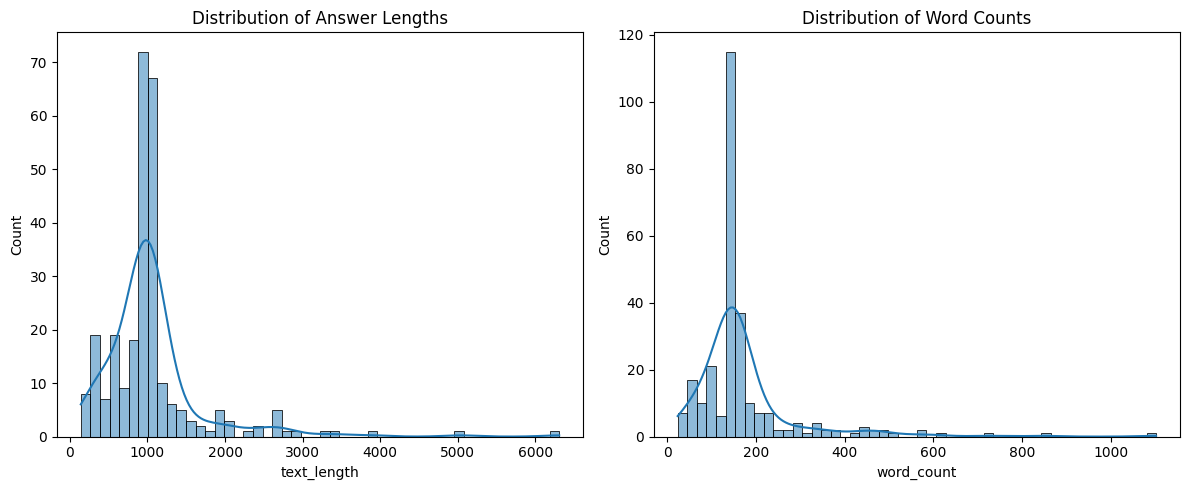

In [39]:
print("\n🔍 Target value distribution:")
print(train_df['is_cheating'].value_counts(normalize=True))

train_df['text_length'] = train_df['answer'].astype(str).apply(len)
train_df['word_count'] = train_df['answer'].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_df['text_length'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Answer Lengths")

sns.histplot(train_df['word_count'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Word Counts")

plt.tight_layout()
plt.show()

In [40]:
train = pd.read_csv("../Mecor_Data/train.csv")
test = pd.read_csv("../Mecor_Data/test.csv")

In [41]:
X = train['answer']
y = train['is_cheating']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train_tfidf, y_train)

y_pred = model.predict_proba(X_val_tfidf)[:, 1]
roc = roc_auc_score(y_val, y_pred)

print(f"✅ ROC-AUC Score: {roc:.4f}")

✅ ROC-AUC Score: 0.9667


In [42]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(train_df['answer'])
y = train_df['is_cheating']

models = {
    "lr": LogisticRegression(max_iter=1000, solver='liblinear'),
    "rf": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "xgb": XGBClassifier(eval_metric='logloss', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42),
    "lgb": LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=-1, random_state=42, verbose=-1)
}

for name, model in models.items():
    score = cross_val_score(model, X, y, cv=kf, scoring='roc_auc').mean()

ensemble = VotingClassifier(estimators=list(models.items()), voting='soft')
ensemble_score = cross_val_score(ensemble, X, y, cv=kf, scoring='roc_auc').mean()
print(f"Ensemble ROC-AUC: {ensemble_score:.4f}")

Ensemble ROC-AUC: 0.8709


In [43]:
ensemble.fit(X, y)
X_test_tfidf = vectorizer.transform(test_df['answer'])
test_preds = ensemble.predict_proba(X_test_tfidf)[:, 1]

submission = pd.DataFrame({
    "answer_id": test_df["id"],
    "score": test_preds
})

submission.to_csv("ensemble_submission.csv", index=False)
print("✅ Submission saved as ensemble_submission.csv")

✅ Submission saved as ensemble_submission.csv


In [44]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words='english')
X_tfidf = vectorizer.fit_transform(train_df['answer'])
y = train_df['is_cheating']

models = {
    "lr": LogisticRegression(max_iter=1000, solver='liblinear'),
    "rf": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "xgb": XGBClassifier(eval_metric='logloss', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42),
    "lgb": LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42, verbose=-1)
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((len(y), len(models)))
test_preds = np.zeros((len(test_df), len(models)))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tfidf, y)):
    X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    for j, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        oof_preds[val_idx, j] = model.predict_proba(X_val)[:, 1]
        test_preds[:, j] += model.predict_proba(vectorizer.transform(test_df['answer']))[:, 1] / kf.n_splits

meta_features = pd.DataFrame(oof_preds, columns=models.keys())
test_meta = pd.DataFrame(test_preds, columns=models.keys())
print(f"Meta features shape: {meta_features.shape} | Test meta shape: {test_meta.shape}")

Meta features shape: (269, 4) | Test meta shape: (264, 4)


In [45]:
meta_model = LogisticRegression(max_iter=1000)

meta_model.fit(oof_preds, y)

final_preds = meta_model.predict_proba(test_preds)[:, 1]

submission = pd.DataFrame({
    "answer_id": test_df["id"],
    "score": final_preds
})

submission.to_csv("stacked_submission.csv", index=False)
print("✅ Final stacked model submission saved as stacked_submission.csv")
submission.head()

✅ Final stacked model submission saved as stacked_submission.csv


,answer_id,score
0,scr_81822029c661,0.433588
1,scr_52efb19e0ea9,0.737583
2,scr_8fc0f33c559e,0.340163
3,scr_bac3f5d3aa12,0.222599
4,scr_adfbe009984d,0.431138


In [46]:
meta_X = meta_features
meta_y = y

meta_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
meta_model.fit(meta_X, meta_y)

meta_oof_preds = meta_model.predict_proba(meta_X)[:, 1]
meta_auc = roc_auc_score(meta_y, meta_oof_preds)
print(f"\n✅ Meta-model (stacked) ROC-AUC on OOF data: {meta_auc:.4f}")

test_meta = pd.DataFrame(test_preds, columns=models.keys())
final_preds = meta_model.predict_proba(test_meta)[:, 1]

submission = pd.DataFrame({
    'answer_id': test['id'],
    'score': final_preds
})
submission.to_csv("stacked_submission.csv", index=False)
submission.head()


✅ Meta-model (stacked) ROC-AUC on OOF data: 1.0000


,answer_id,score
0,scr_81822029c661,0.657733
1,scr_52efb19e0ea9,0.999027
2,scr_8fc0f33c559e,0.954864
3,scr_bac3f5d3aa12,0.000870
4,scr_adfbe009984d,0.006311


In [47]:
sub = pd.read_csv("stacked_submission.csv")
sub.rename(columns={"answer_id": "id"}, inplace=True)
sub.to_csv("stacked_submission_2.csv", index=False)

In [48]:
sub = pd.read_csv("stacked_submission.csv")
sub.rename(columns={"answer_id": "id"}, inplace=True)
sub.to_csv("stacked_submission_2.csv", index=False)

sub.head()

,id,score
0,scr_81822029c661,0.657733
1,scr_52efb19e0ea9,0.999027
2,scr_8fc0f33c559e,0.954864
3,scr_bac3f5d3aa12,0.000870
4,scr_adfbe009984d,0.006311


In [49]:
sub1 = pd.read_csv("stacked_submission_2.csv")
sub2 = pd.read_csv("ensemble_submission.csv")

In [50]:
sub2.rename(columns={"answer_id": "id"}, inplace=True)

blend = sub1.merge(sub2, on="id", suffixes=("_stacked", "_ensemble"))

blend["score"] = 0.6 * blend["score_stacked"] + 0.4 * blend["score_ensemble"]

blend[["id", "score"]].to_csv("super_blend_submission.csv", index=False)
print("✅ Super blend submission saved as super_blend_submission.csv")

blend.head()

✅ Super blend submission saved as super_blend_submission.csv


,id,score_stacked,score_ensemble,score
0,scr_81822029c661,0.657733,0.359615,0.538486
1,scr_52efb19e0ea9,0.999027,0.705723,0.881705
2,scr_8fc0f33c559e,0.954864,0.446762,0.751623
3,scr_bac3f5d3aa12,0.000870,0.395549,0.158741
4,scr_adfbe009984d,0.006311,0.497560,0.202811


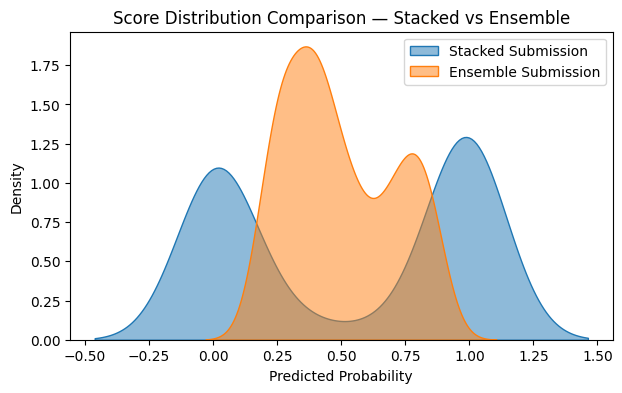

In [51]:
plt.figure(figsize=(7, 4))
sns.kdeplot(blend["score_stacked"], label="Stacked Submission", fill=True, alpha=0.5)
sns.kdeplot(blend["score_ensemble"], label="Ensemble Submission", fill=True, alpha=0.5)
plt.title("Score Distribution Comparison — Stacked vs Ensemble")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

---

## 🏁 Results & Notes

- Best model: **Stacked LGBM meta-learner**
- Public Leaderboard Score: **0.95384**
- Base models: Logistic Regression, Random Forest, XGBoost, LightGBM
- Meta features created via 5-Fold Stratified CV
- Final files:
  - `stacked_submission.csv`
  - `stacked_submission_2.csv`
  - `super_blend_submission.csv`

📅 *Project completed: October 2025*